In [307]:
#hide
! [ -e /content ] && pip install -Uqq fastbook
import fastbook
fastbook.setup_book()
from fastbook import *
from fastai.data.external import *
from ipywidgets import *
import pandas as pd
import numpy as np
import math
import sqlite3
from random import randint

In [308]:
# Local stuff
from api.helpers import *
import api.tab_model as tm
import api.imageclassifier as ic
from api.location_model import LocationModel
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [310]:
image_file = "dbs/training/training-data-v0-4.csv"
source_images = pd.read_csv(image_file)
source_images = source_images.loc[source_images.imgid.notna()]
source_images['img'] = 'dbs/images/500/' + source_images.gbifid.astype(str) + '-' + source_images.imgid.astype(int).astype(str) + '.png'
species_images = source_images[['img', 'species']]
species_images


,img,species
8,dbs/images/500/2983765339-1.png,Leptoporus mollis
60,dbs/images/500/1428858500-1.png,Lactarius necator
61,dbs/images/500/1428858500-2.png,Lactarius necator
62,dbs/images/500/1428858500-3.png,Lactarius necator
81,dbs/images/500/1433233463-1.png,Gomphidius glutinosus
...,...,...
12025628,dbs/images/500/3424155912-1.png,Paralepista flaccida
12025629,dbs/images/500/3424155884-1.png,Cladonia uncialis
12025630,dbs/images/500/3424155890-1.png,Pleurotus pulmonarius
12025632,dbs/images/500/3424155893-1.png,Lichenomphalia umbellifera


In [313]:
import re
p = re.compile('dbs/images/500/([0-9]+)-.*')

def get_x(a):
    return a[0]
def get_y(a):
    return a[1]

mush = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    splitter=FuncSplitter(lambda o: (int(p.match(o[0]).group(1)) % 10) < 2),
    get_x=get_x,
    get_y=get_y, 
    item_tfms=Resize(460, pad_mode=PadMode.Zeros),
    batch_tfms=[*aug_transforms(size=224, pad_mode=PadMode.Zeros, min_scale=.75)])

In [314]:
batch_size = 128
dls = mush.dataloaders(species_images.to_numpy(), bs=batch_size)

In [325]:

learn = vision_learner(dls, 
                       resnet101
                       )

learn = learn.load('v0.4/resnet101-f10-fp16-augs_9')

In [327]:
learn.export('models/v0.4/resnet101-f10-fp16-augs_9.pkl')

In [328]:
img_learn = ic.ImageClassifier('models/v0.4/resnet101-f10-fp16-augs_9.pkl')

In [320]:
tab_learn = tm.TabModel('dbs/fungid.sqlite')
loc_learn = LocationModel('dbs/fungid.sqlite')

In [321]:
file = "dbs/training/training-data-v0-4.csv"
data = pd.read_csv(file)
data = data.loc[data.imgid.notna()].copy()
data['img'] = 'dbs/images/500/' + data.gbifid.astype(str) + '-' + data.imgid.astype(int).astype(str) + '.png'

In [322]:
def get_bounding_box(lat, lon, dist):
    latdiff = (180 / math.pi) * (dist / 6378137)
    londiff = (180 / math.pi) * (dist / 6378137) / math.cos(lat)
    return (lat - latdiff, lon - londiff), (lat + latdiff, lon + londiff)

def get_db_species(conn, observation, dist):
    p1, p2 = get_bounding_box(tab_item.decimallatitude, tab_item.decimallongitude, dist)
    print(p1, p2)
    cursor = conn.execute("""
    SELECT species, COUNT(*)
    FROM validobservations v 
    JOIN trainingspecies t ON v.specieskey = t.specieskey
    WHERE decimallatitude BETWEEN ? AND ? 
    AND decimallongitude BETWEEN ? AND ? 
    GROUP BY 1 ORDER BY 2;""",
                 (p1[0], p2[0], p1[1], p2[1]))
    results = cursor.fetchall()
    print(len(results))
    
def get_tab_data(data):
    tab_columns = ['kg', 'elu_class1', 'elu_class2', 'elu_class3', 'decimallatitude', 'decimallongitude', 'species', 'normalizedmonth', 'season']
    return data[tab_columns].copy()

def get_results(learner, data):
    row, clas, probs = learner.predict(data)
    return probs
                 


1336661
gbifid                                   1088918843
_family                                Parmeliaceae
genus                                      Letharia
species                            Letharia vulpina
familykey                                    8305.0
genuskey                                    2605402
specieskey                                  2605403
eventyear                                      2015
eventmonth                                        3
eventday                                         14
eventdate                       2015-03-14 00:00:00
decimallatitude                           38.367471
decimallongitude                        -122.507571
kg                                                9
elu                                            1604
elu_class1                       Warm Wet Mountains
elu_class2                         Acidic Volcanics
elu_class3               Grassland, Scrub, or Shrub
normalizedmonth                                   4
seas

,prob0,rank0,0,1,0,1,likelihood
species,,,,,,,
Letharia vulpina,0.919773,1.0,0.556372,1.0,0.556372,1.0,0.604902
Evernia mesomorpha,0.043189,2.0,0.028286,2.0,NaN,NaN,0.654935
Letharia columbiana,0.013776,3.0,0.009956,3.0,NaN,NaN,0.722677
Usnea hirta,0.011892,4.0,0.007910,4.0,NaN,NaN,0.665161
Evernia prunastri,0.001427,5.0,0.001067,5.0,0.001067,2.0,0.748087
Ramalina farinacea,0.000952,6.0,0.000702,6.0,0.000702,3.0,0.737383
Alectoria sarmentosa,0.000223,7.0,0.000121,8.0,NaN,NaN,0.542027
Ramalina menziesii,0.000153,8.0,0.000151,7.0,0.000151,4.0,0.985645
Evernia divaricata,0.000150,9.0,0.000087,11.0,NaN,NaN,0.578152


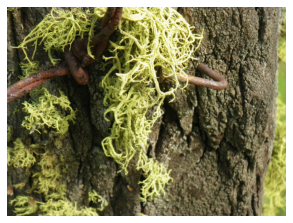

In [371]:
def compare(probs, vals, num) -> pd.DataFrame:

    df = pd.DataFrame()
    for i, prob in enumerate(probs):
        if i == 0:
            df["prob" + str(i)] = prob
            df["rank" + str(i)] = prob.rank(ascending=False)
        else: 
            df = pd.concat([df, prob, prob.rank(ascending=False)], axis=1)

    df = pd.concat([df] + vals, axis=1)

    return df.sort_values(by="rank0").head(num)


id = randint(0, len(img_data))
# id = 124978 # bad pic
# id = 193834 # & 2073568- Totall throws the data into mayhem 
# id = 1370890 # - Ignore Surface Water in ELU?
# id = 3728825706 # - bad lichen 

print(id)
item = data.iloc[id]
print(item)
PILImage.create(item.img).show()
images = list(data.loc[data.gbifid == item.gbifid].img)
print(images)
obs = obs_from_series(item, images)

loc_preds = loc_learn.get_predictions(obs.lat, obs.long)
tab_preds = tab_learn.get_predictions(obs)
print((tab_preds.max(), tab_preds.min(), tab_preds.loc[tab_item.species]))

img_preds, img_df = img_learn.get_predictions(obs.images)

df = compare([img_preds, 
              img_preds * tab_preds,
              (img_preds * tab_preds).loc[loc_preds.index]
             ], [tab_preds], 50)
df

# 2238561578

In [261]:
img_df.sort_values(by="0", ascending=False)

,0,1
species,,
Panus conchatus,21.042353,16.658409
Pleurotus pulmonarius,16.273634,16.519880
Pleurotus ostreatus,16.180414,15.065679
Lenzites betulinus,15.551631,16.919554
Panus neostrigosus,14.042208,14.673512
...,...,...
Strobilomyces strobilaceus,0.408175,3.857002
Suillus americanus,0.362640,5.565790
Chlorophyllum olivieri,0.202737,6.143771


In [205]:
probs = [img_preds, 
         img_preds * tab_preds,
         (img_preds * tab_preds).loc[loc_preds.index]
        ]

df = pd.DataFrame()
for i, prob in enumerate(probs):
    if i == 0:
        df["prob" + str(i)] = prob
        df["rank" + str(i)] = prob.rank(ascending=False)
    else: 
        df = pd.concat([df, prob, prob.rank(ascending=False)], axis=1)

    
df
# (img_preds * tab_preds).loc[loc_preds.index]

,prob0,rank0,0,1,0,1
species,,,,,,
Abortiporus biennis,-11.112320,2767.0,-17.522710,2240.0,-17.522710,1319.0
Acanthophysium oakesii,-6.217802,1092.0,-15.527212,1985.0,NaN,NaN
Acarospora fuscata,-5.913771,900.0,-17.303498,2211.0,-17.303498,1300.0
Acarospora moenium,-5.424222,671.0,-14.617180,1850.0,-14.617180,1060.0
Acarospora sinopica,-7.454016,1756.0,-17.666347,2260.0,-17.666347,1332.0
...,...,...,...,...,...,...
Xylodon flaviporus,-8.361444,2177.0,-20.473418,2528.0,NaN,NaN
Xylodon radula,-6.460116,1219.0,-15.530566,1986.0,-15.530566,1146.0
Xylodon sambuci,-10.604612,2721.0,-21.413704,2595.0,-21.413704,1554.0


In [362]:
image = PILImage.create('/Users/weishuhn/Downloads/29619110964_47ac61c8d7_h.jpg')
# img_learn.resize(image)
pred, _ = img_learn.get_predictions([image])
compare([pred], [], 50)

,prob0,rank0
species,,
Amanita phalloides,0.541044,1.0
Volvopluteus gloiocephalus,0.086653,2.0
Phallus impudicus,0.050740,3.0
Amanita vaginata,0.031479,4.0
Amanita arctica,0.026542,5.0
Bovista plumbea,0.019013,6.0
Amanita virosa,0.017612,7.0
Amanita velosa,0.013704,8.0
Agaricus xanthodermus,0.011762,9.0


In [364]:
img_learn.learner

In [219]:
type(df.sum(axis=1))

pandas.core.series.Series

In [ ]:
url = 'https://inaturalist-open-data.s3.amazonaws.com/photos/3897840/large.jpg'
filename = 'tmp/tmp.jpg'
resized = 'tmp/tmp-resized.jpg'
resize = Resize(224, ResizeMethod.Pad, pad_mode='zeros')
download_url(url, filename)
img = PILImage.create(filename)
resize(img).save(resized)
test_probs = get_results(img_learn, resized)
print_top50(test_probs)